In [1]:
import glob
import os
from importlib import reload

import contextily as ctx
import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from rasterio.plot import show

import claude_temp.grid_analysis as ga
from project_config import get_config
from src import composite_analysis as ca
from src import pipeline

cfg = get_config()
paths = cfg.paths
data_folder = paths.get_path('data')
raw_folder = paths.get_path('raw')
clipped_folder = paths.get_path('clipped')
stacked_folder = paths.get_path('stacked')
derived_folder = paths.get_path('derived')
classified_folder = paths.get_path('classified')
grid_analysis_folder = paths.get_path('grid_analysis')
proximity_analysis_folder = paths.get_path('proximity_analysis')
rois_folder = paths.get_path('rois')
rois_initial_analysis_dir = paths.get_path('rois_initial')
tests_folder = paths.get_path('tests')
envi_folder = paths.get_path('envi')

bands_to_keep = cfg.bands.to_dict()
band_map = cfg.band_map.to_dict()
composites = cfg.composites.get_all()
all_rois = cfg.rois.all_rois

In [2]:
# Default figure size
plt.rcParams['figure.figsize'] = (10, 8)

# Default font sizes
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

# Optional: line widths and marker sizes
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 6

# Deeper Analysis



In [ ]:
reload(ca)

test_classified_tif = str(classified_folder) + '/LC08_L2SP_109060_20160603_20200907_02_T1_classified.tif'
class_path = test_classified_tif

with rasterio.open(test_classified_tif) as src:
    class_array = src.read(1)
    profile = src.profile.copy()
class_array

array([[254, 254, 254, ...,   0,   0,   0],
       [254, 254, 254, ...,   0,   0,   0],
       [254, 254, 254, ...,   0,   0,   0],
       ...,
       [  1,   1,   1, ...,   3,   3,   3],
       [  1,   1,   1, ...,   3,   3,   3],
       [  1,   1,   1, ...,   3,   3,   3]],
      shape=(2412, 1725), dtype=uint16)

[0 1 2]


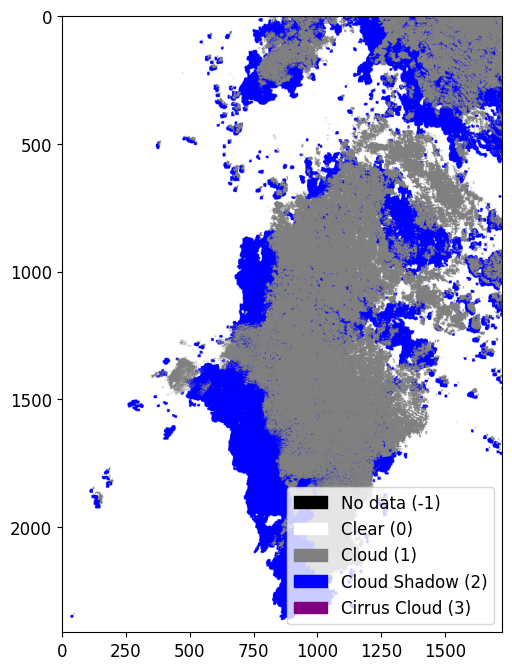

In [7]:
from matplotlib.patches import Patch
reload(ca)
qa_path = str(clipped_folder) + '/LC08_L2SP_109060_20160603_20200907_02_T1/QA_PIXEL'
cloud_mask, cloud_map, cloud_ignore = ca.get_cloud_mask_from_qa_pixel_explicit(qa_path)

print(np.unique(cloud_mask))

plt.figure(figsize=(10, 8))
cmap = plt.cm.colors.ListedColormap(['black', 'white', 'gray', 'blue', 'purple'])
bounds = [-1.5, -0.5, 0.5, 1.5, 2.5, 3.5]
norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

plt.imshow(cloud_mask, cmap=cmap, norm=norm)
legend_elements = [
    Patch(color='black', label='No data (-1)'),
    Patch(color='white', label='Clear (0)'),
    Patch(color='gray', label='Cloud (1)'),
    Patch(color='blue', label='Cloud Shadow (2)'),
    Patch(color='purple', label='Cirrus Cloud (3)'),
]
plt.legend(handles=legend_elements, loc='lower right')
plt.show()

{1: 'cloud', 2: 'No data', 3: 'Cloud', np.int64(4): 'Jungle', np.int64(5): 'Cleared', np.int64(6): 'Ocean'}
[  1   2   3   4   5   6 257]
[[257 257 257 ...   3   1   1]
 [257 257 257 ...   1   1   1]
 [257 257 257 ...   1   1   1]
 ...
 [  4   4   4 ...   6   6   6]
 [  4   4   4 ...   6   6   6]
 [  4   4   4 ...   6   6   6]]


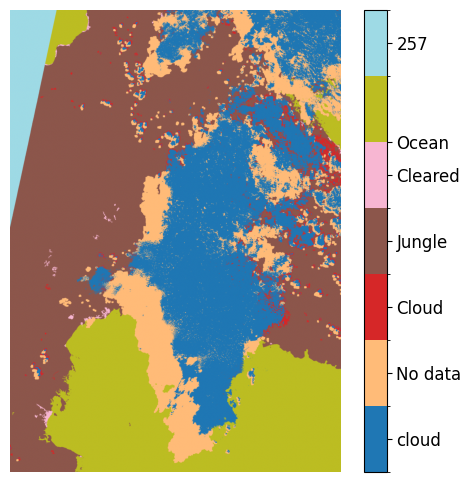

In [8]:
reload(ga)
reload(ca)
# class_path = classified_folder
# with rasterio.open(class_path) as pen:
#     p = pen.read(1)
classified_map = cfg.classifier.int_class_mapping
combi, combi_map = ga.combine_raster_arrays(cloud_mask, class_array, map1=cloud_map, map2=classified_map, nodata1=cloud_ignore)

print(combi_map)
print(np.unique(combi))
print(combi)

def plot_combined_raster(combined, class_map):
    """
    combined: 2D array from combine_raster_arrays
    class_map: dict mapping numeric values to class names
    """
    # Get unique values in the raster
    unique_vals = np.unique(combined)
    
    # Make a discrete colormap
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_vals)))
    cmap = mcolors.ListedColormap(colors)
    
    # Make a norm that maps unique values to color indices
    bounds = unique_vals - 0.5
    bounds = np.append(bounds, unique_vals[-1] + 0.5)
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    plt.figure(figsize=(6,6))
    im = plt.imshow(combined, cmap=cmap, norm=norm)
    plt.axis('off')
    
    # Create a colorbar with class names
    cbar = plt.colorbar(im, ticks=unique_vals)
    cbar.ax.set_yticklabels([class_map.get(val, str(val)) for val in unique_vals])
    plt.show()

plot_combined_raster(combi, combi_map)

In [9]:
import sys
if 'claude_temp.grid_analysis' in sys.modules:
    del sys.modules['claude_temp.grid_analysis']

reference = str(envi_folder) + r'/clipped' # the base file upon which we base our CRS and bounding box; common to all generated files
with rasterio.open(reference) as src:
    bounds = src.bounds
    crs = src.crs

classifier = cfg.classifier # maps the int values in classified raster files to the type, e.g. jungle, cleared, ocean, etc.; colours also

grid_size = 2500
cloud_threshold = 0.3
cloud_mask = [1,1,0] # 0 - cloud mask, 1 - cloud shadow mask, 2 - cirrus mask

# class_path = "output/classified/LC08_L2SP_109060_20160603_20200907_02_T1_classified.tif"
# ndvi_path = "claude_temp/derived/test/NDVI"
# qa_path = "claude_temp/derived/test/QA_PIXEL"

ga.mask_raster_with_cloud(qa_path, class_path)

grid_gdf = ga.create_grid(bounds, grid_size, crs)
print(f'Grid: {len(grid_gdf)} cells')

g = ga.mask_grid_cells(grid_gdf, qa_path, class_path, cloud_mask=cloud_mask, ocean_mask=True)
g.plot()


AttributeError: module 'claude_temp.grid_analysis' has no attribute 'mask_raster_with_cloud'

In [ ]:
combined_mask, class_data, extent = ga.build_combined_mask(class_path, qa_path)
ga.plot_combined_mask(class_data, combined_mask, extent)

classified_grid = ga.apply_mask_to_grid(grid_gdf, class_path, qa_path, 100, cloud_threshold=0.3)
classified_grid.plot(column='dominant_class', categorical=True, legend=True, figsize=(10,8))

grid_with_ndvi = ga.compute_mean_ndvi_per_cell(classified_grid, ndvi_path)
ga.plot_ndvi_with_mask(grid_with_ndvi)
ga.plot_grid_ndvi_over_raster(ndvi_path, grid_with_ndvi)


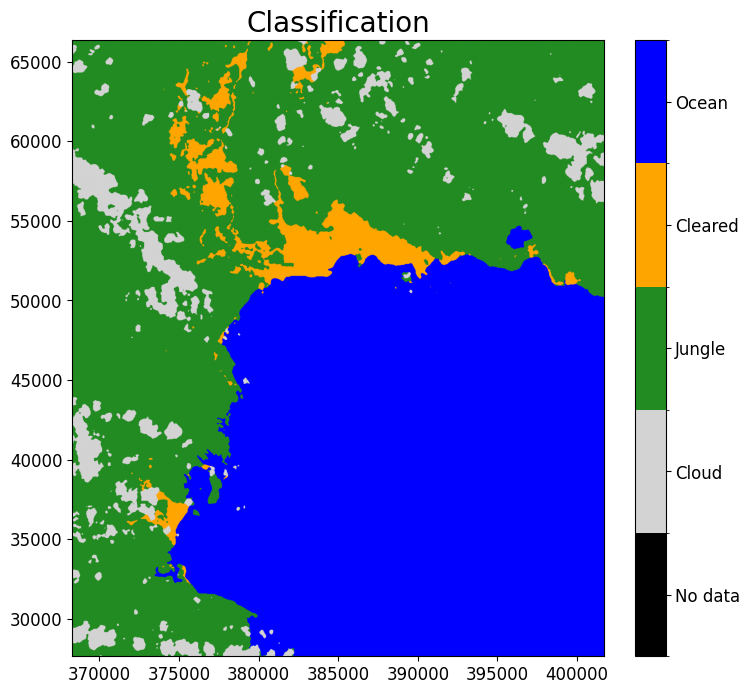

In [ ]:

# class values and labels (adjust to your mapping)
class_vals = [-1, 0, 1, 2, 3]
labels = ['No data', 'Cloud', 'Jungle', 'Cleared', 'Ocean']

# colours in the same order as class_vals
cmap = mcolors.ListedColormap(['black', 'lightgrey', 'forestgreen', 'orange', 'blue'])
bounds = [-1.5, -0.5, 0.5, 1.5, 2.5, 3.5]  # boundaries between integer classes
norm = mcolors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(10, 8))
# use the rasterio transform so the plot is georeferenced correctly
show(class_raster, transform=class_profile['transform'], ax=ax, cmap=cmap, norm=norm)
ax.set_title('Classification')
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, ticks=class_vals, fraction=0.046, pad=0.04)
cbar.ax.set_yticklabels(labels)
plt.show()

In [12]:
# Weda Bay Watch - Spatial Analysis Examples
# This notebook demonstrates the new grid and proximity analysis workflows

import sys
sys.path.append('..')

from src import pipeline
from claude_temp import classification, grid_analysis, proximity_analysis
from project_config import get_config
import pandas as pd
import numpy as np

# reload(grid_analysis)

# =============================================================================
# 1. SETUP & CONFIGURATION
# =============================================================================

# Load or create config
cfg = get_config()

# Optionally save default config for future editing
# cfg.save_to_json('config.json')

# Access configuration
print("Composites:", cfg.composites.enabled)
print("Grid size:", cfg.analysis.grid_size_meters, "meters")
print("Buffer distances:", cfg.analysis.buffer_distances_meters)

# =============================================================================
# 2. WORKING WITH CLASSIFICATION FILES
# =============================================================================

# Example: Read a classification file and extract mine boundary
scene_name = "test"
class_path = test_classified_tif

# Read classification
class_array, profile = classification.read_classification_raster(class_path)
print(f"Classification shape: {class_array.shape}")
print(f"Unique classes: {np.unique(class_array)}")

# Get mine boundary as polygon
mine_boundary = classification.get_mine_boundary(
    class_path,
    buffer_meters=0,  # No buffer
    simplify_tolerance=10  # Simplify by 10m
)
print(f"Mine boundary area: {mine_boundary.geometry.area.values[0] / 1e6:.2f} km²")

# Get forest mask
forest_mask = classification.get_forest_mask(class_array)
print(f"Forest pixels: {forest_mask.sum():,}")

# =============================================================================
# 3. GRID-BASED ANALYSIS
# =============================================================================

# Create a grid over the study area
index_path = f"claude_temp/derived/{scene_name}/NDVI"
with rasterio.open(index_path) as src:
    bounds = src.bounds
    crs = src.crs

grid_gdf = grid_analysis.create_grid(
    bounds=bounds,
    cell_size_meters=cfg.analysis.grid_size_meters,
    crs=crs
)
print(f"Created grid with {len(grid_gdf)} cells")

# Compute statistics for one scene
grid_with_stats = grid_analysis.compute_grid_statistics(
    index_path=index_path,
    grid_gdf=grid_gdf,
    qa_path=f"claude_temp/derived/{scene_name}/QA_PIXEL",
    min_valid_fraction=cfg.analysis.min_valid_pixels_pct
)

# Add distance to mine
grid_with_stats = grid_analysis.calculate_distance_to_mine(
    grid_with_stats,
    mine_boundary
)

# View results
print(grid_with_stats[['cell_id', 'mean', 'distance_to_mine_m']].head())



Composites: ['RGB', 'NDVI', 'MNDWI', 'NDBI', 'EVI', 'SAVI', 'FERRIC_IRON', 'BAI', 'SI', 'NDGI', 'NDMI', 'SR', 'BSI', 'FeO']
Grid size: 500 meters
Buffer distances: [500, 1000, 2000, 5000, 10000]
Classification shape: (2412, 1725)
Unique classes: [  0   1   2   3 254]
Mine boundary area: 1647.19 km²
Forest pixels: 9,352
Created grid with 5226 cells


TypeError: compute_grid_statistics() got an unexpected keyword argument 'min_valid_fraction'

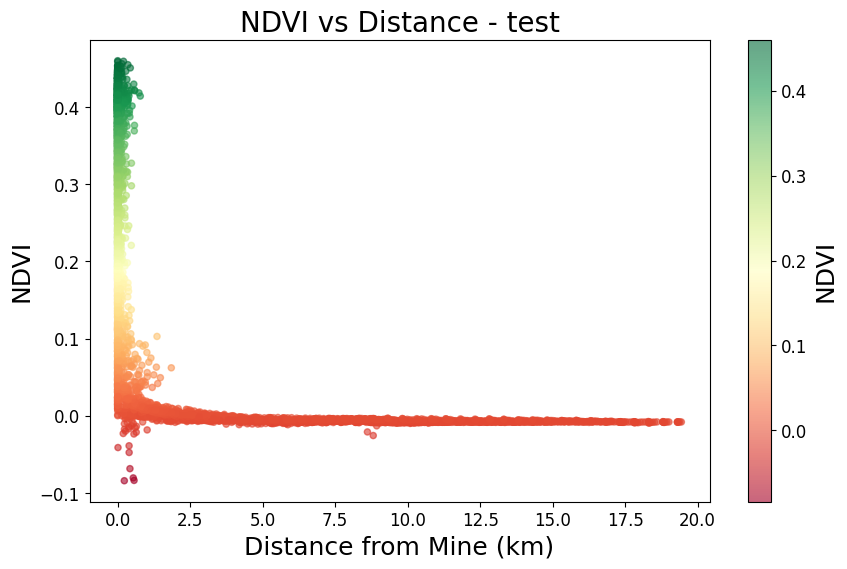

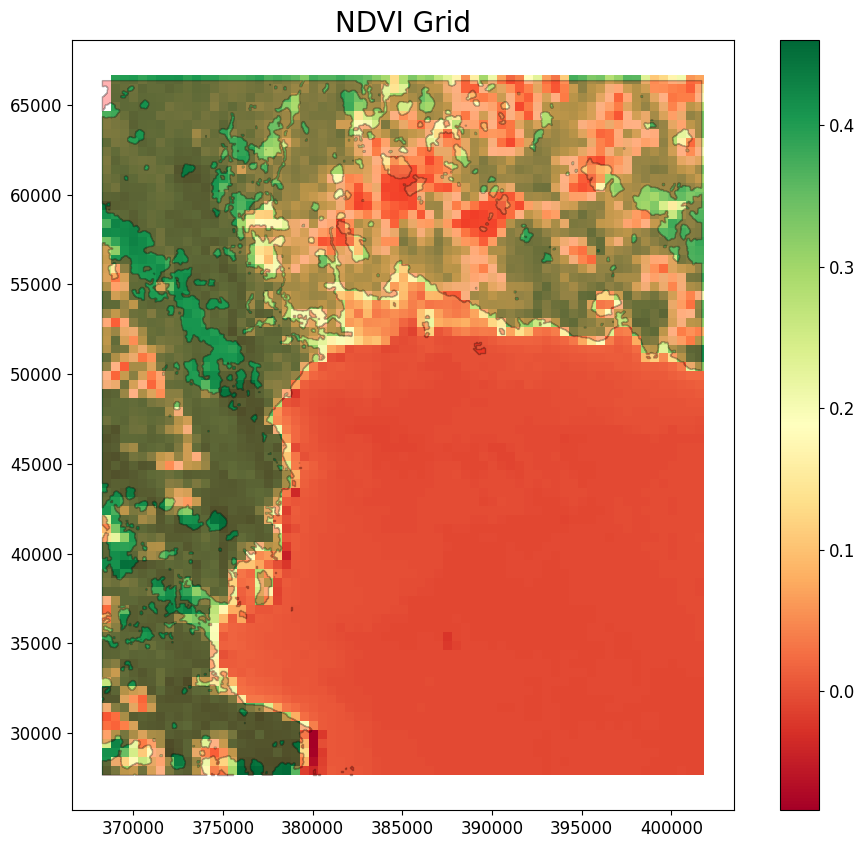

In [ ]:
# Simple scatter plot: Distance vs NDVI
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(
    grid_with_stats['distance_to_mine_m'] / 1000,  # Convert to km
    grid_with_stats['mean'],
    c=grid_with_stats['mean'],
    cmap='RdYlGn',
    alpha=0.6,
    s=20
)
ax.set_xlabel('Distance from Mine (km)')
ax.set_ylabel('NDVI')
ax.set_title(f'NDVI vs Distance - {scene_name}')
plt.colorbar(scatter, label='NDVI')
plt.show()

# Plot as map
fig, ax = plt.subplots(figsize=(12, 10))
grid_with_stats.plot(
    column='mean',
    cmap='RdYlGn',
    legend=True,
    ax=ax,
    edgecolor='none'
)
mine_boundary.plot(ax=ax, facecolor='red', alpha=0.3, edgecolor='black')
ax.set_title('NDVI Grid')
plt.show()

In [ ]:
# =============================================================================
# 4. RUN GRID ANALYSIS FOR ALL SCENES
# =============================================================================

composite = 'NDVI'  # or any other from cfg.composites.enabled

grid_results = grid_analysis.grid_analysis_all_scenes(
    derived_folder='data/derived',
    clipped_folder='data/clipped',
    classified_folder='data/classified',
    output_folder=f'output/grid_analysis/{composite}',
    composite_name=composite,
    grid_size_meters=cfg.analysis.grid_size_meters,
    min_valid_fraction=cfg.analysis.min_valid_pixels_pct
)

print(f"Processed {len(grid_results)} scenes")

# =============================================================================
# 5. AGGREGATE AND VISUALIZE GRID RESULTS
# =============================================================================

# Aggregate by distance bins
distance_summary = grid_analysis.create_distance_summary(
    grid_results,
    stat='mean',
    distance_bins=[0, 500, 1000, 2000, 5000, 10000, 20000]
)

print("\nNDVI by distance from mine:")
print(distance_summary.describe())

# Plot over time, grouped by distance
grid_analysis.plot_grid_over_time(
    grid_results,
    stat='mean',
    distance_bins=[0, 1000, 2000, 5000, 10000],
    figsize=(14, 8)
)

# =============================================================================
# 6. PROXIMITY/BUFFER ANALYSIS
# =============================================================================

# Run proximity analysis for all scenes
proximity_df = proximity_analysis.proximity_analysis_all_scenes(
    derived_folder='data/derived',
    clipped_folder='data/clipped',
    classified_folder='data/classified',
    output_folder='output/proximity_analysis',
    composite_name='NDVI',
    buffer_distances=cfg.analysis.buffer_distances_meters
)

print("\nProximity analysis results:")
print(proximity_df.head())

# =============================================================================
# 7. VISUALIZE PROXIMITY RESULTS
# =============================================================================

# Plot NDVI over time at different distances
proximity_analysis.plot_proximity_over_time(
    proximity_df,
    buffer_distances=cfg.analysis.buffer_distances_meters,
    stat='mean',
    composite_name='NDVI',
    figsize=(14, 8)
)

# Calculate trends for each buffer zone
trends_df = proximity_analysis.calculate_proximity_trends(
    proximity_df,
    buffer_distances=cfg.analysis.buffer_distances_meters,
    stat='mean'
)

print("\nLinear trends by distance:")
print(trends_df)

# Compare mine vs far forest
proximity_analysis.compare_mine_vs_forest(
    proximity_df,
    mine_distance=500,  # 500m from mine
    forest_distance=10000,  # 10km from mine
    stat='mean',
    composite_name='NDVI'
)

# =============================================================================
# 8. MULTI-INDEX ANALYSIS
# =============================================================================

# Run for multiple composites
for composite in ['NDVI', 'EVI', 'SAVI', 'MNDWI']:
    print(f"\nProcessing {composite}...")
    
    proximity_df = proximity_analysis.proximity_analysis_all_scenes(
        derived_folder='data/derived',
        clipped_folder='data/clipped',
        classified_folder='data/classified',
        output_folder=f'output/proximity_analysis',
        composite_name=composite,
        buffer_distances=[500, 1000, 2000, 5000, 10000]
    )
    
    # Calculate trends
    trends = proximity_analysis.calculate_proximity_trends(
        proximity_df,
        buffer_distances=[500, 1000, 2000, 5000, 10000],
        stat='mean'
    )
    
    print(f"\n{composite} Trends:")
    print(trends[['slope_per_year', 'p_value', 'r_squared']])

# =============================================================================
# 9. EXPORT RESULTS
# =============================================================================

# Export distance summary for all scenes
distance_summary.to_csv('output/ndvi_distance_summary.csv')

# Export trends
trends_df.to_csv('output/ndvi_proximity_trends.csv')

print("\nAnalysis complete! Results saved to output/")

In [5]:
# === GRID ANALYSIS - COMPLETE TEST WITH DEBUG ===

# Reload modules
import sys
if 'claude_temp.grid_analysis' in sys.modules:
    del sys.modules['claude_temp.grid_analysis']

import rasterio
import claude_temp.grid_analysis as ga
from claude_temp.grid_analysis import create_grid, compute_grid_statistics
from project_config import get_config

reload(ga)

cfg = get_config()
classifier = cfg.classifier

class_path = "output/classified/LC08_L2SP_109060_20160603_20200907_02_T1_classified.tif"
ndvi_path = "claude_temp/derived/test/NDVI"
qa_path = "claude_temp/derived/test/QA_PIXEL"

grid_size = 100
cloud_threshold = 0.3

with rasterio.open(class_path) as src:
    bounds = src.bounds
    crs = src.crs

grid_gdf = create_grid(bounds, grid_size, crs)
print(f"Grid: {len(grid_gdf)} cells; CRS: {grid_gdf.crs}")

with rasterio.open(class_path) as pok:
    print(pok.bounds)
    print(pok.crs)
    print(pok.shape)
with rasterio.open(ndvi_path) as pok:
    print(pok.bounds)
    print(pok.crs)
    print(pok.shape)
with rasterio.open(qa_path) as pok:
    print(pok.bounds)
    print(pok.crs)
    print(pok.shape)

g = ga.mask_grid_cells(grid_gdf, qa_path, class_path)


combined_mask, class_data, extent = ga.build_combined_mask(class_path, qa_path)
ga.plot_combined_mask(class_data, combined_mask, extent)

classified_grid = ga.apply_mask_to_grid(grid_gdf, class_path, qa_path, 100, cloud_threshold=0.3)
classified_grid.plot(column='dominant_class', categorical=True, legend=True, figsize=(10,8))

grid_with_ndvi = ga.compute_mean_ndvi_per_cell(classified_grid, ndvi_path)
ga.plot_ndvi_with_mask(grid_with_ndvi)
ga.plot_grid_ndvi_over_raster(ndvi_path, grid_with_ndvi)


Grid: 375032 cells; CRS: PROJCS["WGS 84 / UTM zone 52N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",129],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32652"]]
BoundingBox(left=368985.0, bottom=27645.0, right=420735.0, top=100005.0)
EPSG:32652
(2412, 1725)
BoundingBox(left=368295.0, bottom=27645.0, right=401685.0, top=66345.0)
EPSG:32652
(1290, 1113)
BoundingBox(left=368295.0, bottom=27645.0, right=401685.0, top=66345.0)
EPSG:32652
(1290, 1113)


TypeError: mask_grid_cells() missing 1 required positional argument: 'int_mapping'

In [26]:
qa_paths = [os.path.join(clipped_folder, s, 'QA_PIXEL') for s in os.listdir(clipped_folder)]

props = []
for qa in qa_paths:
    cm, _, _ = ca.get_cloud_mask_from_qa_pixel_explicit(qa)
    prop = np.isin(cm, [1, 2]).sum() / cm.size

    props.append([qa, prop])

for i in props:
    print(i)


['data\\clipped\\LC08_L2SP_109060_20131017_20200912_02_T1\\QA_PIXEL', np.float64(0.19177181724229095)]
['data\\clipped\\LC08_L2SP_109060_20160127_20200907_02_T1\\QA_PIXEL', np.float64(0.23357752301295456)]
['data\\clipped\\LC08_L2SP_109060_20160212_20200907_02_T1\\QA_PIXEL', np.float64(0.03295503160525873)]
['data\\clipped\\LC08_L2SP_109060_20160502_20200907_02_T1\\QA_PIXEL', np.float64(0.21516908212560387)]
['data\\clipped\\LC08_L2SP_109060_20160603_20200907_02_T1\\QA_PIXEL', np.float64(0.37822217415338766)]
['data\\clipped\\LC08_L2SP_109060_20161110_20200905_02_T1\\QA_PIXEL', np.float64(0.35786117720575866)]
['data\\clipped\\LC08_L2SP_109060_20170505_20200904_02_T1\\QA_PIXEL', np.float64(0.1311397120676809)]
['data\\clipped\\LC08_L2SP_109060_20171012_20200903_02_T1\\QA_PIXEL', np.float64(0.34062080899848585)]
['data\\clipped\\LC08_L2SP_109060_20171129_20200902_02_T1\\QA_PIXEL', np.float64(0.5601211334631192)]
['data\\clipped\\LC08_L2SP_109060_20171231_20200902_02_T1\\QA_PIXEL', np.fl

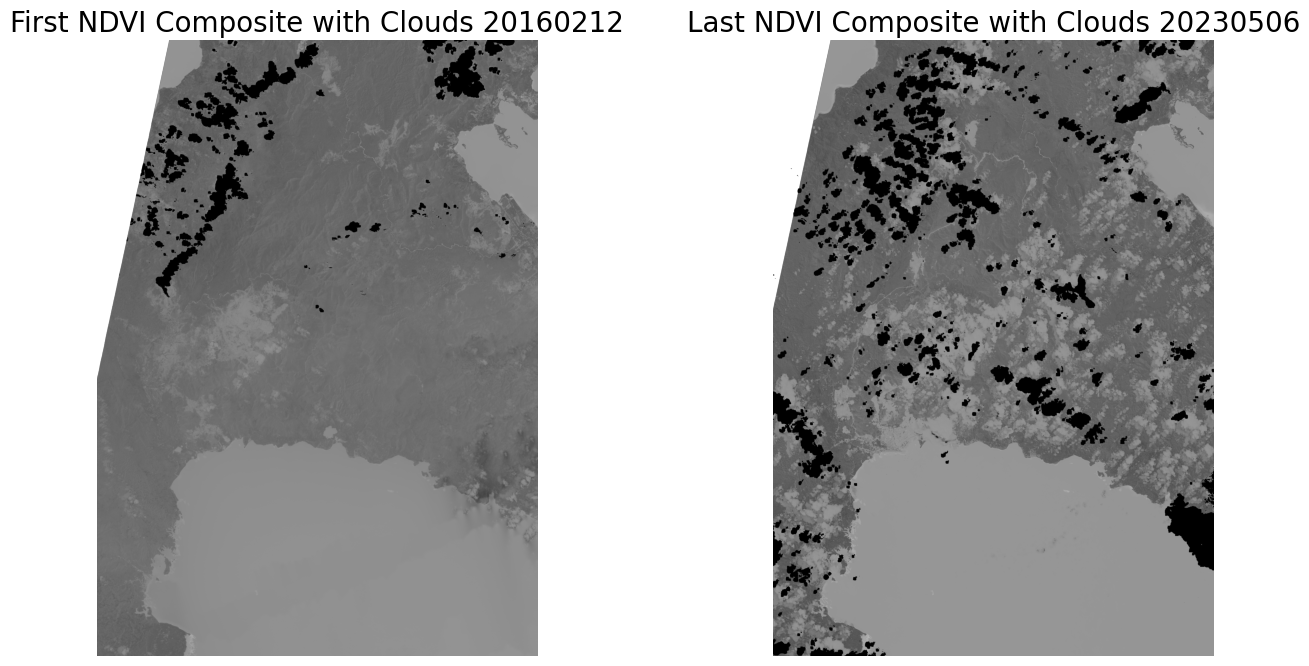

{1: 'cloud', 2: 'cloud_shadow', 3: 'cirrus'}

In [48]:
first = 'LC08_L2SP_109060_20160212_20200907_02_T1'
# last = 'LC09_L2SP_109060_20250722_20250725_02_T1' # shit
last = 'LC09_L2SP_109060_20240226_20240228_02_T1'
# last = 'LC08_L2SP_109060_20250220_20250226_02_T1'
# last = 'LC09_L2SP_109060_20250316_20250317_02_T1'
# last = 'LC09_L2SP_109060_20231005_20231006_02_T1' # shit
# last = 'LC08_L2SP_109060_20231216_20240103_02_T1'
last ='LC08_L2SP_109060_20240202_20240208_02_T1'
last ='LC08_L2SP_109060_20230506_20230509_02_T1'

first_ndvi = os.path.join(derived_folder, 'LC08_L2SP_109060_20160212_20200907_02_T1/NDVI')
last_ndvi = os.path.join(derived_folder, 'LC09_L2SP_109060_20250722_20250725_02_T1/NDVI')
first_qa = os.path.join(clipped_folder, first, 'QA_PIXEL')
last_qa = os.path.join(clipped_folder, last, 'QA_PIXEL')

# open rasters
with rasterio.open(first_ndvi) as src1:
    ndvi1 = src1.read(1)
with rasterio.open(last_ndvi) as src2:
    ndvi2 = src2.read(1)

cm1, cloud_map, _ = ca.get_cloud_mask_from_qa_pixel_explicit(first_qa)
cm2, _, _ = ca.get_cloud_mask_from_qa_pixel_explicit(last_qa)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# First NDVI
axes[0].imshow(ndvi1, cmap='Greys', vmin=-1, vmax=1)
# overlay clouds
axes[0].imshow(np.where(np.isin(cm1, [1, 2]), 1, np.nan), cmap='gray', alpha=1)  # 1 = cloud in your mask
axes[0].set_title(f'First NDVI Composite with Clouds {pipeline.extract_scene_date(first)}')
axes[0].axis('off')

# Last NDVI
axes[1].imshow(ndvi2, cmap='Greys', vmin=-1, vmax=1)
# overlay clouds
axes[1].imshow(np.where(np.isin(cm2, [1, 2]), 1, np.nan), cmap='gray', alpha=1)
axes[1].set_title(f'Last NDVI Composite with Clouds {pipeline.extract_scene_date(last)}')
axes[1].axis('off')

plt.show()

cloud_map
